<a href="https://colab.research.google.com/github/parhambarazesh/PET575/blob/master/AutomatedMPD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

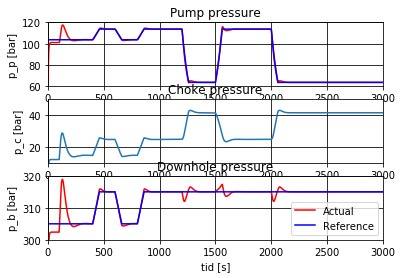

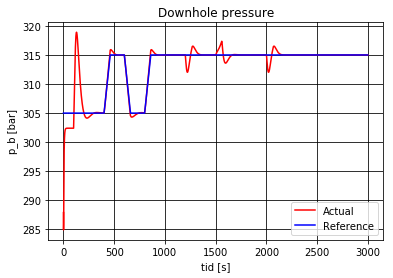

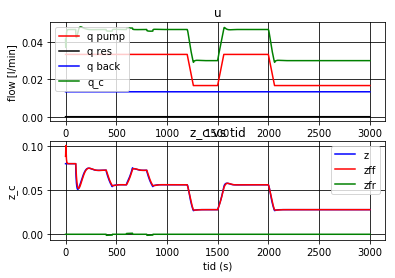

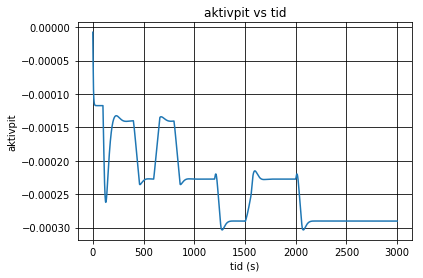

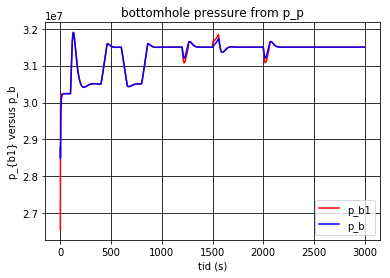

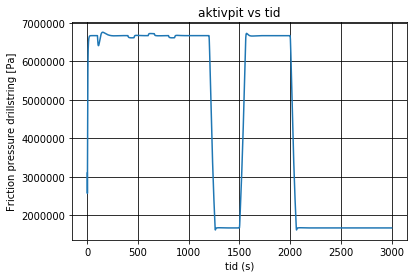

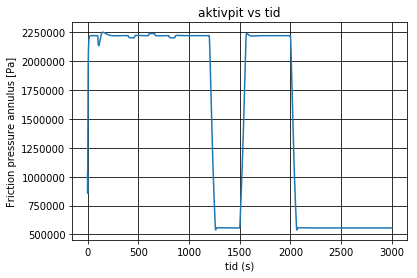

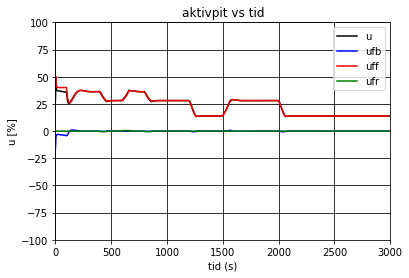

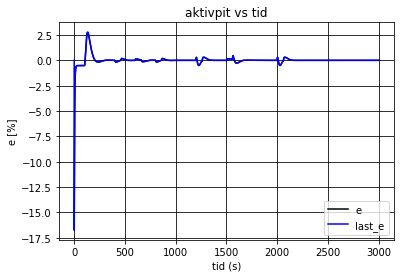

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# parameter definition
# Hard-coded
Cin2m = 2.54e-2     # [m/in]    Convert inch to meters

# Struct with fixed parameters
g     = 9.81     # [m/s2]    Gravitational acceleration
rho   = 1580     # [kg/m3]   Density of mud
h_dh  = 1729     # [m]       Vertical depth downhole sensor - smt: TVD av q_bit
L     = 1951     # [m]       Total length of well
Di_d = (4+5/32)*Cin2m# [m]  Inner diameter"
Do_d = 5*Cin2m  # [m]   Outer diameter "
D_a=(8+5/8)*Cin2m

# calculation of system parameters in simplified model
# Units in m3/s, Pa, m

A_di=np.pi*(Di_d/2)**2
A_do=np.pi*(Do_d/2)**2
A_a=np.pi*(D_a/2)**2
V_d=np.pi*(Di_d/2)**2*L
V_a=np.pi*(D_a/2)**2*L-np.pi*(Do_d/2)**2*L
#rho_d=rho/1e5 %???
rho_d=rho
rho_a=rho_d
rho_res=1768.2
h_bit=h_dh
M_d=rho_d*L/A_di # density per meter of the drillstring
M_a=rho_a*L/A_a # density per meter of the annulus
M = M_d + M_a

# in unit [bar-1]
#beta_a = 1.0865e+004;%
#beta_d =  2.2855e+004;%
# in unit [Pa-1]
beta_a = 1.0865e+009
beta_d =  2.2855e+009
 
F_d=6e9 # for [Pa] % Approx 60 bar friction pressure in drillstring
# 7.3%198.4;%86600*0.9;%
F_a=2e9 # for [Pa] # Approx 20 bar friction pressure in annulus
# 7.3;%1198.4%86600*0.9;%
#F_a=2.3;%153.95%155%12000*0.60
#F_d=86600*0.9
#F_a=12000*0.60

#Sample time
Ts = 1	 # main loop 1 second	
dt = 0.01 # Euler forward simulation, typical 10 ms
# max iterations
maxIterate  = 3000 # seconds

#initial values
q_p = 2000/60000 # m3/s
q_c = 2800/60000 # m3/s
q_back = 800/60000 # m3/s
#q_back = 0/60000 # m3/s
q_res = 0 # m3/s
q_b = 2000/60000 # m3/s
V_a_dot = 0
p_p = 20e5
p_c = 10e5
k_c = 0.021 # valve constant
z_c = 0.08#0.002 #åpning på ventil
z_c_0 = 0.080#0.002; #åpning på ventil, initial value
zfr = 0
zff = 0
prodindex = 0.0002#0.0000005;
p_res = rho_res*g*h_bit
aktivpit=0
p_b=rho_d*g*h_bit
p_b1 = p_b
p_p_r = 0
p_p_r_old = 0
p_f_d = 0
p_f_a = 0

#reference values 
p_bhp_r  = 3.05*10**7
p_bhp_r_old  = p_bhp_r
e = 0

#PI controller paramerers
Kp = 1.00
Ki = 0.030

# scaling min_max
p_min=0*10**7 # p_p_m
#p_min=2.5*10**7 # p_bhp_m
p_max=5.0*10**7 # p_bhp_m
z_min=0
z_max=0.20
#valve_max_rate= 0.004;
valve_max_rate= 1
# Tasks:
# Use p_p as measured variable
# Calculate p_p_r as a function of pf_d and p_b 
ufb = 0
ufr_integral = 0
ufr_last = 0
hpf_ufr = 0
ufr = 0

Array=np.array([np.zeros(24)])
for i in range(0,maxIterate+1):
    # Reference adjustment

    # Adjustment of downhole pressure reference
    if  (i > 400) and (i <= 460):# 400 sec
        p_bhp_r  = p_bhp_r + 0.10*10**7/60

    if  (i > 600) and (i <= 660):# 600 sec
        p_bhp_r  = p_bhp_r - 0.10*10**7/60

    if  (i > 800) and (i <= 860):# 800 sec
        p_bhp_r  = p_bhp_r + 0.10*10**7/60

    p_p_r = p_bhp_r - rho_d*g*h_bit + F_d*q_p*q_p
    
    # Disturbances adjustment ( pumps etc.
    #Update disturbance
    if (i >= 1200) and (i < 1200+60):
        q_p = q_p- 0.0002777# [m3/s] (ramp down by 1000 l/min in one minute)
    
    if (i >= 1260) and (i < 1500):
        q_p = 0.01667# [m3/s] (1000 l/min)
    
    if (i >= 1500) and (i < 1500+60):
        q_p = q_p+ 0.0002777# [m3/s] (ramp up by 1000 l/min in one minute)
    
    if i >= (1500+60) and (i < 2000):
        q_p = 0.03333# [m3/s] (2000 l/min)

    if (i >= 2000) and (i < 2000+60):
        q_p = q_p- 0.0002777# [m3/s] (ramp down by 1000 l/min in one minute)
    
    if i >= (2000+60):
        q_p = 0.01667# [m3/s] (3000 l/min)
    
    # First order filter on disturbances and references 
    # not necessary yet....
   
    # Controller
    # calculate z feed forward disturbance
    #zff = qinn/(Kv*sqrt(rho*g*h)) % tank modell
    zff = (q_p + q_back) /(k_c*np.sqrt(p_c/rho_a)) # annulus model
    
    # calculate z feed forward reference
    # assume p_p_dot approx p_c_dot
    #zfr = (A*(h_setp_old-h_setp))/(Kv*sqrt(rho*g*h)) # tank modell
    #zfr = ((V_a/beta_a)*(p_p_r_old-p_p_r))/(k_c*sqrt(p_c/rho_a)) # annulus modell
    zfr = ((V_a/beta_a)*(p_bhp_r_old-p_bhp_r))/(k_c*np.sqrt(p_c/rho_a)) # annulus modell
    p_p_r_old = p_p_r
    p_bhp_r_old = p_bhp_r
    
    #scale process variables to controller
    #Controlled variable p_php
    r = ((p_p_r-p_min)/p_max)*100.0 # reference is p_p
    y = ((p_p-p_min)/p_max)*100.0 # controlled variable
    #Controlled variable p_php
    #r = ((p_bhp_r-p_min)/p_max)*100.0 # reference is p_bhp
    #y = ((p_b-p_min)/p_max)*100.0 # controlled variable
    #Manipulated variable
    u = ((z_c-z_min)/z_max)*100.0 # manipulated variable
    uff = ((zff-z_min)/z_max)*100.0 # manipulated variable
    ufr_last = ufr
    ufr = ((zfr-z_min)/z_max)*100.0 # manipulated variable
    
    #uff = 0; # turn off feedforward disturbance
    #ufr = 0; # turn off feedforward reference
    #ufb = u-uff-ufr;
    #Store previous values
    
    # PI Controller
    last_e = e
    e=y-r
    #delta_u=Kp*(e-last_e)+((Kp*Ts)/Ti)*e; % using Kp and Ti
    delta_u=Kp*(e-last_e)+(Ki*Ts)*e # using Kp and Ki
    
    ufb=ufb+delta_u # feedback
    
    u = ufb +uff + ufr
    
    if u<=0:
        u=0

    if u>100:
        u=100
    
    #scale controller variables to process
    z_c_old = z_c
    z_c = z_min + z_max*(u/100.0)

    #End controller
    # Selection of controller active
    if  i <= 100: # 100 sec
        z_c = z_c_0

    # Limit z_c velocity
    if np.abs(z_c-z_c_old) > valve_max_rate:
        z_c = z_c_old + np.sign(z_c-z_c_old)*valve_max_rate
        #disp('limiting valve speed');
    #     last_e = 0;
    #     e = 0;
    # Simulate system at 100 samles per second, dt= 0.01
    
    for counter in range(0,100):
        # system
        p_p_dot = (beta_d/V_d)*(q_p-q_b)
        q_b_dot = (1/M)*((p_p-p_c)- F_d*q_b*q_b - F_a*q_b*q_b+(rho_d-rho_a)*g*h_bit)
        p_c_dot = (beta_a/V_a)*(q_b+q_res+q_back-q_c-V_a_dot)
        
        #time integration using Euler
        p_p = p_p + dt*p_p_dot
        q_b = q_b + dt*q_b_dot
        p_c = p_c + dt*p_c_dot

        # Update process variables
        # p_c = (1/rho)*
        if p_c<0:
            q_c=0
        else:
            p_b1  = p_p+rho_d*g*h_bit-F_d*q_b*q_b
          
            # p_p_test = p_b1 - rho_d*g*h_bit + F_d*q_b*q_b
            # p_p_test1 = p_c + F_a*q_b*q_b + F_d*q_b*q_b
            #p_b-p_b1
          
            p_b = p_c+rho_a*g*h_bit+F_a*q_b*q_b
            q_c = z_c*k_c*np.sqrt(p_c/rho_a)
            aktivpit=aktivpit+((q_c-q_p-q_back)/60000)
            p_f_d = F_d*q_b*q_b
            p_f_a = F_a*q_b*q_b
    
    # Store values
    time = (i)*Ts
    data=np.array([[time,p_p,p_c,q_b,q_back,q_p,q_res,q_c,z_c,p_b,aktivpit,p_bhp_r,p_b1,p_p_r,p_f_d,p_f_a,zff,zfr,u,ufb,uff,ufr,e,last_e]])

    #Array(i,:) = [time,p_p,p_c,q_b,q_back,q_p,q_res,q_c,z_c,p_b,aktivpit,p_bhp_r,p_b1,p_p_r,p_f_d,p_f_a,zff,zfr,u,ufb,uff,ufr,e,last_e];
    Array=np.concatenate((Array,data),axis=0)


# Plotting
Array=np.delete(Array,0,0)


time_ar=Array[:,0];
p_p_ar=Array[:,1]
p_c_ar=Array[:,2]
q_b_ar=Array[:,3]
q_back_ar=Array[:,4]
q_p_ar=Array[:,5]
q_res_ar=Array[:,6]
q_c_ar=Array[:,7]
z_c_ar=Array[:,8]
p_b_ar=Array[:,9]
aktivpit_ar=Array[:,10]
p_bhp_r_ar=Array[:,11]
p_b1_ar=Array[:,12]
p_p_r_ar=Array[:,13]
p_f_d_ar=Array[:,14]
p_f_a_ar=Array[:,15]
zff_ar=Array[:,16]
zfr_ar=Array[:,17]
u_ar=Array[:,18]
ufb_ar=Array[:,19]
uff_ar=Array[:,20]
ufr_ar=Array[:,21]
e_ar=Array[:,22]
last_e_ar=Array[:,23]


plt.figure(1)
plt.subplot(3,1,1)
plt.plot(time_ar[1:],p_p_ar[1:]*1e-5,'r')
plt.plot(time_ar[1:],p_p_r_ar[1:]*1e-5,'b')
plt.xlabel('tid [s]')
plt.ylabel('p_p [bar]')
plt.axis([1,maxIterate,60,120])
plt.title('Pump pressure')
plt.grid(color='k')

plt.subplot(3,1,2)
plt.plot(time_ar[1:],p_c_ar[1:]*1e-5)
plt.xlabel('tid [s]')
plt.ylabel('p_c [bar]')
plt.axis([1,maxIterate,10,50])
plt.title('Choke pressure')
plt.grid(color='k')

plt.subplot(3,1,3)
plt.plot(time_ar,p_b_ar*1e-5,'r')
plt.plot(time_ar,p_bhp_r_ar*1e-5,'b')
plt.xlabel('tid [s]')
plt.ylabel ('p_b [bar]')
plt.legend (['Actual','Reference'])
plt.axis([1,maxIterate,300,320])
plt.title ('Downhole pressure')
plt.grid(color='k')

plt.figure(2)
plt.plot(time_ar,p_b_ar*1e-5,'r')
plt.plot(time_ar,p_bhp_r_ar*1e-5,'b')
plt.xlabel('tid [s]')
plt.ylabel('p_b [bar]')
plt.legend(['Actual','Reference'])
#plt.axis([1,maxIterate,90,30])
plt.title ('Downhole pressure')
plt.grid(color='k')

plt.figure(3)
plt.subplot(2,1,1)
plt.plot(time_ar,q_p_ar,'r')
plt.plot(time_ar,q_res_ar,'k')
plt.plot(time_ar,q_back_ar,'b')
plt.plot(time_ar,q_c_ar,'g')
plt.legend(['q pump' , 'q res' , 'q back' , 'q_c'])
plt.xlabel('tid (s)')
plt.ylabel('flow [l/min]')
plt.title('u')
plt.grid(color='k')

plt.subplot(2,1,2)
plt.plot(time_ar,z_c_ar,'b')
plt.plot(time_ar,zff_ar,'r')
plt.plot(time_ar,zfr_ar,'g')
plt.xlabel('tid (s)')
plt.ylabel('z_c')
plt.legend(['z','zff','zfr'])
plt.title('z_c vs tid')
plt.grid(color='k')

plt.figure(4)
plt.plot(time_ar,aktivpit_ar)
plt.xlabel('tid (s)')
plt.ylabel('aktivpit')
plt.title('aktivpit vs tid')
plt.grid(color='k')

plt.figure(5)
#plt.plot(time_ar,p_b1_ar+1e5,'r',time_ar,p_b1_ar,'b')
plt.plot(time_ar,p_b1_ar,'r')
plt.plot(time_ar,p_b_ar,'b')
plt.xlabel('tid (s)')
plt.ylabel('p_{b1} versus p_b')
plt.legend(['p_b1','p_b'])
plt.title('bottomhole pressure from p_p')
plt.grid(color='k')

plt.figure(6)
plt.plot(time_ar,p_f_d_ar)
plt.xlabel('tid (s)')
plt.ylabel('Friction pressure drillstring [Pa]')
plt.title('aktivpit vs tid')
plt.grid(color='k')

plt.figure(7)
plt.plot(time_ar,p_f_a_ar)
plt.xlabel('tid (s)')
plt.ylabel('Friction pressure annulus [Pa]')
plt.title('aktivpit vs tid')
plt.grid(color='k')

plt.figure(8)
plt.plot(time_ar,u_ar,'k')
plt.plot(time_ar,ufb_ar,'b')
plt.plot(time_ar,uff_ar,'r')
plt.plot(time_ar,ufr_ar,'g')
plt.xlabel('tid (s)')
plt.ylabel('u [%]')
plt.legend(['u','ufb','uff','ufr'])
plt.title('aktivpit vs tid')
plt.axis([1,maxIterate,-100,100])
plt.grid(color='k')

plt.figure(9)
plt.plot(time_ar,e_ar,'k')
plt.plot(time_ar,last_e_ar,'b')
plt.xlabel('tid (s)')
plt.ylabel('e [%]')
plt.legend(['e','last_e'])
plt.title('aktivpit vs tid')
#plt.axis([1,maxIterate,-100,100])
plt.grid(color='k')